In [1]:
import ast
import random
import pickle
import json
from collections import OrderedDict
import warnings
import threading
from multiprocessing.pool import ThreadPool
import concurrent.futures

import pandas as pd
import numpy as np
import seaborn as sns
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFdr
from scipy.stats import chi2
from patsy import ModelDesc, dmatrix

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

rbg_cols = fg.loc[fg['bg_type'] == 'RBG'].index
fbg_cols = fg.loc[fg['bg_type'] == 'FBG'].index
data_cols = rbg_cols.append(fbg_cols)

data = pd.read_csv(r'..\data\interim\interim_combined_metab_lipid_table.csv', index_col=0).set_index('i').T
data = data.filter(regex='RBG|FBG', axis=0)
data = data.astype('float')
features = data.columns
data = data.join(fg[['bg_type', 'bg', 'week', 'gluc_tol', 'animal', 'ogtt', 'litter']])

### ENCODING WEEK AND LITTER AS A CATEGORICAL STRING INSTEAD OF NUMERIC ###
data[['week', 'litter']] = data[['week', 'litter']].astype('str')  

weight_insulin = fg['animal'].apply(lambda x: ap.loc[x, ['Insulin (AUC)', 'Weightprefastweek12']])
data = data.join(weight_insulin)
data.rename({'bg_type': 'sampling', 
             'Insulin (AUC)': 'insulin', 
             'Weightprefastweek12': 'weight'}, 
            inplace=True, axis=1)
data

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_872,sampling,bg,week,gluc_tol,animal,ogtt,litter,insulin,weight
1102_8_RBG,16.861652,22.144573,22.576981,23.803795,24.596731,23.371599,22.847897,23.547123,25.628650,22.996484,...,16.200014,RBG,299.500000,8,impaired,1102,1738.25,3,651.9385,121.3
1093_9_RBG,16.671317,20.963399,23.843259,24.316310,26.201371,23.332309,23.054384,23.325673,23.161769,23.245015,...,15.915763,RBG,83.000000,9,normal,1093,993.00,2,377.1690,94.5
1060_8_FBG,17.594730,20.198771,23.895235,24.714910,17.148994,22.653452,22.084504,21.397206,26.744550,22.065355,...,19.836798,FBG,41.000000,8,impaired,1060,1761.75,0,294.3430,105.1
1060_8_RBG,20.826956,21.959743,23.754788,24.235682,17.431244,23.211817,22.667628,22.998237,25.603477,22.896178,...,16.202162,RBG,225.000000,8,impaired,1060,1761.75,0,294.3430,105.1
1060_9_FBG,21.809716,20.524661,24.263211,24.520405,19.169210,23.207043,22.450039,21.424020,25.018418,22.534742,...,20.234283,FBG,48.000000,9,impaired,1060,1761.75,0,294.3430,105.1
1060_9_RBG,22.730565,21.240594,19.532128,23.866956,26.312933,23.109947,22.595668,22.956542,25.443791,22.718984,...,16.494586,RBG,83.000000,9,impaired,1060,1761.75,0,294.3430,105.1
1060_10_FBG,18.748109,20.303969,23.084387,24.792384,27.209158,22.793616,22.563256,21.784634,25.548330,22.664376,...,19.279616,FBG,52.500000,10,impaired,1060,1761.75,0,294.3430,105.1
1060_10_RBG,18.990099,22.020890,23.528259,23.998058,25.956118,23.454379,22.935395,23.571467,25.378341,23.056140,...,15.240250,RBG,206.000000,10,impaired,1060,1761.75,0,294.3430,105.1
1062_8_FBG,18.098242,21.019048,24.873347,24.787384,21.774699,23.221875,22.352220,21.964129,26.812682,22.346725,...,18.585339,FBG,52.333333,8,impaired,1062,1648.75,0,687.6300,109.1
1062_8_RBG,18.060936,22.271482,23.321162,23.858506,26.822243,23.272693,23.005211,23.224943,26.221461,23.180628,...,16.471090,RBG,256.500000,8,impaired,1062,1648.75,0,687.6300,109.1


In [3]:
y_3class = fg['gluc_tol']         # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                            # random/fasted blood glucoose
ogtt_dict = ap['OGTT (AUC)'].to_dict() 
y_ogtt = fg['animal'].map(ogtt_dict)  

# Code is simplified from the original mixed effects and fixed effects method. 
### Now only Fixed Effects are calculated 
### More predictors are included in model
### `statsmodels.api.stats.anova_lm` simplifies calculating significance for each variable using likelihood ratio test (ANOVA) on nested model 

In [8]:
data

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_872,sampling,bg,week,gluc_tol,animal,ogtt,litter,insulin,weight
1102_8_RBG,16.861652,22.144573,22.576981,23.803795,24.596731,23.371599,22.847897,23.547123,25.628650,22.996484,...,16.200014,RBG,299.500000,8,impaired,1102,1738.25,3,651.9385,121.3
1093_9_RBG,16.671317,20.963399,23.843259,24.316310,26.201371,23.332309,23.054384,23.325673,23.161769,23.245015,...,15.915763,RBG,83.000000,9,normal,1093,993.00,2,377.1690,94.5
1060_8_FBG,17.594730,20.198771,23.895235,24.714910,17.148994,22.653452,22.084504,21.397206,26.744550,22.065355,...,19.836798,FBG,41.000000,8,impaired,1060,1761.75,0,294.3430,105.1
1060_8_RBG,20.826956,21.959743,23.754788,24.235682,17.431244,23.211817,22.667628,22.998237,25.603477,22.896178,...,16.202162,RBG,225.000000,8,impaired,1060,1761.75,0,294.3430,105.1
1060_9_FBG,21.809716,20.524661,24.263211,24.520405,19.169210,23.207043,22.450039,21.424020,25.018418,22.534742,...,20.234283,FBG,48.000000,9,impaired,1060,1761.75,0,294.3430,105.1
1060_9_RBG,22.730565,21.240594,19.532128,23.866956,26.312933,23.109947,22.595668,22.956542,25.443791,22.718984,...,16.494586,RBG,83.000000,9,impaired,1060,1761.75,0,294.3430,105.1
1060_10_FBG,18.748109,20.303969,23.084387,24.792384,27.209158,22.793616,22.563256,21.784634,25.548330,22.664376,...,19.279616,FBG,52.500000,10,impaired,1060,1761.75,0,294.3430,105.1
1060_10_RBG,18.990099,22.020890,23.528259,23.998058,25.956118,23.454379,22.935395,23.571467,25.378341,23.056140,...,15.240250,RBG,206.000000,10,impaired,1060,1761.75,0,294.3430,105.1
1062_8_FBG,18.098242,21.019048,24.873347,24.787384,21.774699,23.221875,22.352220,21.964129,26.812682,22.346725,...,18.585339,FBG,52.333333,8,impaired,1062,1648.75,0,687.6300,109.1
1062_8_RBG,18.060936,22.271482,23.321162,23.858506,26.822243,23.272693,23.005211,23.224943,26.221461,23.180628,...,16.471090,RBG,256.500000,8,impaired,1062,1648.75,0,687.6300,109.1


In [4]:
# Showing the design matrix for the model 

all_terms = ['ogtt', 'sampling',  'sampling:ogtt', 'insulin', 'week', 'weight', 'litter']
feature = 'l_872'
full_formula = f'{feature} ~ ' + ' + '.join(all_terms) 
full_model = smf.ols(full_formula, data=data).fit()
full_model.model.formula

dmatrix_data = data[['l_872', 'ogtt', 'sampling', 'insulin', 'week', 'weight', 'litter']].to_dict('list')
md = ModelDesc.from_formula(full_model.model.formula, )
dm = dmatrix(full_model.model.formula.split('~ ')[1], data=dmatrix_data)
# np.asarray(dm)
# dm

In [6]:
def fit_anova_fixed_effects(feature):
    all_terms = ['ogtt', 'sampling',  'sampling:ogtt', 
#                  'insulin', 'week', 'weight', 'litter'
                ]

    full_formula = f'{feature} ~ ' + ' + '.join(all_terms) 
    full_model = smf.ols(full_formula, data=data).fit()

    params = full_model.params.to_dict()
    params = {'model_param_' + key: value for key, value in params.items()}

    anova_df = sm.stats.anova_lm(full_model, typ=1)
    anova_df = anova_df.loc[~anova_df.index.isin(['Residual']), 'PR(>F)']
    anova_df = anova_df.to_dict()
    anova_df = {'pval_' + key: value for key, value in anova_df.items()}
    
    return {**anova_df, **params}

In [7]:
fer = []  # fer = Fixed Effects Result
# Run model for each 
for feature in features:
    fer.append(fit_anova_fixed_effects(feature))
fer = pd.DataFrame(fer, index=features)

# FDR correction
for i, pval_col in enumerate(fer.filter(regex='pval')):
    fdr_col_name = 'qval_' + pval_col.split('pval_')[1]
    fer.insert(i, fdr_col_name, fdrcorrection(fer[pval_col])[1])
    
fer

,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,
m_0,5.928611e-01,0.000031,0.620705,5.336933e-01,0.000003,0.495986,14.960875,-0.787034,0.002166,0.000655
m_1,4.915771e-10,0.002260,0.000415,1.098935e-10,0.000464,0.000013,20.983077,-0.976809,-0.000127,0.001139
m_2,1.835438e-01,0.751390,0.803014,1.423899e-01,0.635885,0.725216,23.336732,-0.056476,-0.000029,-0.000169
m_3,9.910100e-11,0.058097,0.495794,1.978064e-11,0.025241,0.368794,24.992686,-0.981715,-0.000293,0.000166
m_4,4.046428e-01,0.039559,0.337231,3.470290e-01,0.015871,0.213602,29.760575,-2.837744,-0.003309,0.002223
...,...,...,...,...,...,...,...,...,...,...
l_868,1.127899e-02,0.001780,0.001529,6.881459e-03,0.000347,0.000134,20.216223,-2.099050,-0.000057,0.001603
l_869,6.502325e-02,0.433296,0.001745,4.490627e-02,0.303278,0.000164,20.036803,-3.601004,-0.000961,0.002588
l_870,6.765239e-09,0.228991,0.002301,1.791460e-09,0.133921,0.000251,20.541737,-4.135453,-0.000509,0.001666


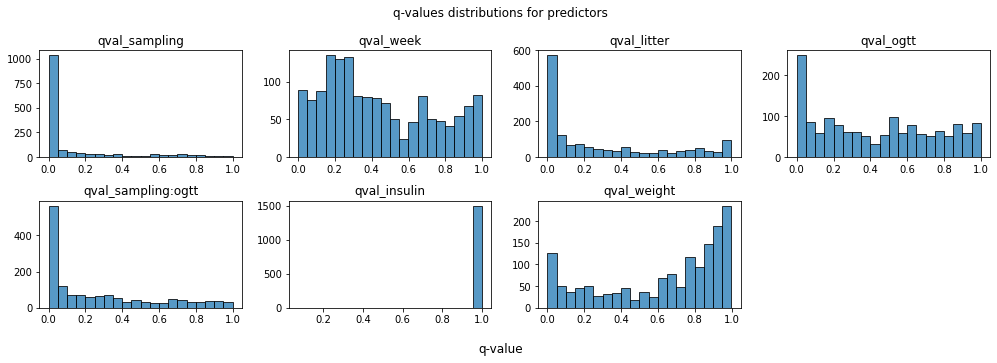

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=4, )
fig.set_size_inches(14, 5)
fig.suptitle('q-values distributions for predictors')
fig.supxlabel('q-value')
for i, qval in enumerate(fer.filter(regex='qval')):
    ax = axs[i//4][i%4]
    sns.histplot(fer[qval], bins=20, ax=ax)
    ax.set_title(qval)
    ax.set_ylabel('')
    ax.set_xlabel('')
axs[1][3].remove()
plt.tight_layout()

In [8]:
# Write results
# fer.to_csv(r'..\data\interim\mutliomics_fixed_effects_models_results.csv')

In [10]:
full_model

NameError: name 'full_model' is not defined

# Old Mixed effects and Fixed effects code below

In [32]:
def get_model_data(feature_name,
                   value_type,
                   full_model,
                   no_gluc_tol_model,
                   no_sampling_model,
                   no_cross_model,
                   warning_full,
                   warning_gluc_tol,
                   warning_sampling,
                   warning_cross,
                  ):
    
    d = OrderedDict()
    d['feature_name'] = feature_name
    
    d[f'{value_type}_full_model_warnings'] =     (np.nan if not warning_full else warning_full)
    d[f'{value_type}_gluc_tol_model_warnings'] = (np.nan if not warning_gluc_tol else warning_gluc_tol)
    d[f'{value_type}_sampling_model_warnings'] = (np.nan if not warning_sampling else warning_sampling)
    d[f'{value_type}_cross_model_warnings'] =    (np.nan if not warning_cross else warning_cross)
    
    
    d[f'{value_type}_gluc_tol_qval'] = np.nan
    d[f'{value_type}_sampling_qval'] = np.nan
    d[f'{value_type}_cross_qval'] =    np.nan
    
    if value_type == 'ogtt':
        d[f'{value_type}_gluc_tol_pval'] = full_model.compare_lr_test(no_gluc_tol_model)[1]
        d[f'{value_type}_sampling_pval'] = full_model.compare_lr_test(no_sampling_model)[1]  
        d[f'{value_type}_cross_pval'] =    full_model.compare_lr_test(no_cross_model)[1]
    elif value_type == 'NID3class':
        d[f'{value_type}_gluc_tol_pval'] = chi2.sf(2*(full_model.llf - no_gluc_tol_model.llf), 4)
        d[f'{value_type}_sampling_pval'] = chi2.sf(2*(full_model.llf - no_sampling_model.llf), 3)
        d[f'{value_type}_cross_pval'] =    chi2.sf(2*(full_model.llf - no_cross_model.llf), 2)
    else:
        raise ValueError('value_type must be ogtt or NID3class')

#     try: 
#         d[f'{value_type}_full_model_converged'] =     full_model.converged
#         d[f'{value_type}_gluc_tol_model_converged'] = no_gluc_tol_model.converged
#         d[f'{value_type}_sampling_model_converged'] = no_sampling_model.converged
#         d[f'{value_type}_cross_model_converged'] =    no_cross_model.converged
#     except AttributeError:
#         pass
    
    d[f'{value_type}_full_model_ll'] =     full_model.llf
    d[f'{value_type}_no_gluc_tol_ll'] =    no_gluc_tol_model.llf
    d[f'{value_type}_no_sampling_ll'] =     no_sampling_model.llf
    d[f'{value_type}_no_cross_ll'] =       no_cross_model.llf
    
    d[f'{value_type}_full_model_params'] = full_model.params.to_dict()
    d[f'{value_type}_gluc_tol_params'] =   no_gluc_tol_model.params.to_dict()
    d[f'{value_type}_no_sampling_params'] = no_sampling_model.params.to_dict()
    d[f'{value_type}_no_cross_params'] =   no_cross_model.params.to_dict()
    
    return dict(d)

In [33]:
def fit_models(features, df):
    ogtt_result, gluc_tol_result = [], []
    for f in features:
        ### Model with glucose tolerance given in continuous OGTT data
        with warnings.catch_warnings(record=True) as warning_full:
            full =       smf.ols(f'{f} ~ ogtt * bg_type', data=df).fit()
        with warnings.catch_warnings(record=True) as warning_gluc_tol:
            no_ogtt =    smf.ols(f'{f} ~        bg_type', data=df).fit()
        with warnings.catch_warnings(record=True) as warning_sampling:
            no_sampling= smf.ols(f'{f} ~ ogtt          ', data=df).fit()
        with warnings.catch_warnings(record=True) as warning_cross:
            no_cross =   smf.ols(f'{f} ~ ogtt + bg_type', data=df).fit()

            ogtt_result.append(
                get_model_data(
                    feature_name=f,
                    value_type='ogtt',
                    full_model=full,
                    no_gluc_tol_model=no_ogtt,
                    no_sampling_model=no_sampling,
                    no_cross_model=no_cross,
                    warning_full=warning_full,
                    warning_gluc_tol=warning_gluc_tol,
                    warning_sampling=warning_sampling,
                    warning_cross=warning_cross
                ))
        ### Model with glucose tolerance given as categorical, Normal, Impaired or Diabetic
        with warnings.catch_warnings(record=True) as warning_full:
            full =        smf.mixedlm(f'{f} ~ gluc_tol * bg_type', df, groups=df['animal']).fit(maxiter=50, reml=False)
        with warnings.catch_warnings(record=True) as warning_gluc_tol:
            no_gluc_tol = smf.mixedlm(f'{f} ~            bg_type', df, groups=df['animal']).fit(maxiter=50, reml=False)
        with warnings.catch_warnings(record=True) as warning_sampling:
            no_sampling =  smf.mixedlm(f'{f} ~ gluc_tol          ', df, groups=df['animal']).fit(maxiter=50, reml=False)
        with warnings.catch_warnings(record=True) as warning_cross:
            no_cross =    smf.mixedlm(f'{f} ~ gluc_tol + bg_type', df, groups=df['animal']).fit(maxiter=50, reml=False)

            gluc_tol_result.append(
                get_model_data(
                    feature_name=f,
                    value_type='NID3class',
                    full_model=full,
                    no_gluc_tol_model=no_gluc_tol,
                    no_sampling_model=no_sampling,
                    no_cross_model=no_cross,
                    warning_full=warning_full,
                    warning_gluc_tol=warning_gluc_tol,
                    warning_sampling=warning_sampling,
                    warning_cross=warning_cross))  
            
    return ogtt_result, gluc_tol_result

## Test of continuous OGTT Fixed Effects model versus 3-class Mixed Effects model using a random feature:

In [34]:
import random
feature = random.sample(list(feat_cols), 1)[0]
print(feature)
test so = smf.ols(f'{feature} ~ ogtt * bg_type', data=data).fit()
test_r1 = smf.ols(f'{feature} ~     bg_type', data=data).fit()
test_r2 = smf.ols(f'{feature} ~ ogtt       ', data=data).fit()
test_r3 = smf.ols(f'{feature} ~ ogtt + bg_type', data=data).fit()

print('test statistic,        p-value,           difference in df')
print(test.compare_lr_test(test_r1))
print(test.compare_lr_test(test_r2))
print(test.compare_lr_test(test_r3))
print(type(test))

with warnings.catch_warnings(record=True) as w:

    test = smf.mixedlm(f'{feature} ~ gluc_tol + bg_type', data, groups=data['animal']).fit(maxiter=200, reml=False)
    print(test.converged)
    print(type(test))
# print(w)
try:
    print(w[0])
except:
    pass

# test.summary()

test = smf.ols(f'l_555 ~ bg * bg_type', data=data).fit()
display(test.cov_params())
display(test.conf_int())

m_610
test statistic,        p-value,           difference in df
(0.9725530780200415, 0.6149117367161137, 2.0)
(1.9777839761456733, 0.3719886306023936, 2.0)
(0.7653855775756426, 0.38164835720175705, 1.0)
<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
True
<class 'statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper'>
{message : ConvergenceWarning('The MLE may be on the boundary of the parameter space.'), category : 'ConvergenceWarning', filename : 'C:\\Users\\bjanderson23\\anaconda3\\lib\\site-packages\\statsmodels\\regression\\mixed_linear_model.py', lineno : 2237, line : None}


,Intercept,bg_type[T.RBG],bg,bg:bg_type[T.RBG]
Intercept,0.069000,-0.069000,-0.000903,0.000903
bg_type[T.RBG],-0.069000,0.137751,0.000903,-0.001152
bg,-0.000903,0.000903,0.000015,-0.000015
bg:bg_type[T.RBG],0.000903,-0.001152,-0.000015,0.000016


,0,1
Intercept,20.100445,21.152865
bg_type[T.RBG],-3.184168,-1.697170
bg,-0.003715,0.011864
bg:bg_type[T.RBG],-0.007536,0.008629


## Testing effect of adding week as another covariate to full model 

In [54]:
import random
feature = random.sample(list(feat_cols), 1)[0]
# feature = 'm_370'
print(feature)
test    = smf.ols(f'{feature} ~ week + ogtt * bg_type', data=data).fit()
test_r1 = smf.ols(f'{feature} ~ week +        bg_type', data=data).fit()
test_r2 = smf.ols(f'{feature} ~ week + ogtt          ', data=data).fit()
test_r3 = smf.ols(f'{feature} ~        ogtt * bg_type', data=data).fit()
test_r4 = smf.ols(f'{feature} ~ week + ogtt + bg_type', data=data).fit()

print('test statistic,        p-value,           difference in df')
print(test.compare_lr_test(test_r1))
print(test.compare_lr_test(test_r2))
print(test.compare_lr_test(test_r3))
print(test.compare_lr_test(test_r4))

# with warnings.catch_warnings(record=True) as w:
#     test = smf.mixedlm(f'{feature} ~ gluc_tol + bg_type', data, groups=data['animal']).fit(maxiter=200, reml=False)
#     print(test.converged)
#     print(type(test))
# try:
#     print(w[0])
# except:
#     pass

# test.summary()

# test = smf.ols(f'l_555 ~ bg * bg_type', data=data).fit()
# display(test.cov_params())
# display(test.conf_int())

m_370
test statistic,        p-value,           difference in df
(5.2917797269871585, 0.07094219677220286, 2.0)
(0.8203389067398064, 0.6635378018926327, 2.0)
(6.7302730646145505, 0.009479008768033023, 1.0)
(0.08010733245131973, 0.7771520098897984, 1.0)


## Run `fit_models` on data
### Takes about 15 minutes on 1500 features

In [36]:
ogtt_result, gluc_tol_result = fit_models(feat_cols, df=data)

In [37]:
# nidr = NID 3class Result
# ogttr = OGTT Result
nidr = pd.DataFrame(gluc_tol_result).set_index('feature_name')
ogttr = pd.DataFrame(ogtt_result).set_index('feature_name')
nidr

,NID3class_full_model_warnings,NID3class_gluc_tol_model_warnings,NID3class_sampling_model_warnings,NID3class_cross_model_warnings,NID3class_gluc_tol_qval,NID3class_sampling_qval,NID3class_cross_qval,NID3class_gluc_tol_pval,NID3class_sampling_pval,NID3class_cross_pval,NID3class_full_model_ll,NID3class_no_gluc_tol_ll,NID3class_no_sampling_ll,NID3class_no_cross_ll,NID3class_full_model_params,NID3class_gluc_tol_params,NID3class_no_sampling_params,NID3class_no_cross_params
feature_name,,,,,,,,,,,,,,,,,,
m_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237991,4.864391e-01,0.539207,-96.277783,-99.037706,-97.497220,-96.895439,"{'Intercept': 20.09009335934555, 'gluc_tol[T.i...","{'Intercept': 18.48623783160976, 'bg_type[T.RB...","{'Intercept': 20.27252714324454, 'gluc_tol[T.i...","{'Intercept': 20.13314225522255, 'gluc_tol[T.i..."
m_1,NaN,NaN,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('The MLE may be...,NaN,NaN,NaN,0.000030,8.879466e-12,0.000052,-33.144579,-46.216682,-60.382827,-43.011691,"{'Intercept': 20.819010527100897, 'gluc_tol[T....","{'Intercept': 20.777009475513648, 'bg_type[T.R...","{'Intercept': 21.4909624795347, 'gluc_tol[T.im...","{'Intercept': 21.052253916550953, 'gluc_tol[T...."
m_2,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.345577,1.112004e-01,0.159962,-72.135260,-74.372529,-75.139479,-73.968077,"{'Intercept': 23.09736553512502, 'gluc_tol[T.i...","{'Intercept': 23.2889661103759, 'bg_type[T.RBG...","{'Intercept': 23.103714241333115, 'gluc_tol[T....","{'Intercept': 23.269370246177015, 'gluc_tol[T...."
m_3,NaN,NaN,[{message : ConvergenceWarning('The MLE may be...,NaN,NaN,NaN,NaN,0.371157,3.221859e-12,0.413282,-12.590463,-14.723643,-40.860448,-13.474090,"{'Intercept': 24.31912775683528, 'gluc_tol[T.i...","{'Intercept': 24.515768128229865, 'bg_type[T.R...","{'Intercept': 24.031187011429854, 'gluc_tol[T....","{'Intercept': 24.38723525198427, 'gluc_tol[T.i..."
m_4,[{message : ConvergenceWarning('The MLE may be...,NaN,[{message : UserWarning('Random effects covari...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.158235,3.877616e-01,0.347213,-153.084636,-156.387616,-154.597218,-154.142451,"{'Intercept': 23.274576088837374, 'gluc_tol[T....","{'Intercept': 24.374024504715173, 'bg_type[T.R...","{'Intercept': 23.925988452957448, 'gluc_tol[T....","{'Intercept': 23.535628954742336, 'gluc_tol[T...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,NaN,NaN,[{message : ConvergenceWarning('Maximum Likeli...,NaN,NaN,NaN,NaN,0.000704,7.014275e-05,0.000446,-64.014568,-73.636196,-74.938796,-71.730874,"{'Intercept': 20.001463719834668, 'gluc_tol[T....","{'Intercept': 20.12366891715863, 'bg_type[T.RB...","{'Intercept': 20.787835979203912, 'gluc_tol[T....","{'Intercept': 20.5322485889603, 'gluc_tol[T.im..."
l_869,[{message : ConvergenceWarning('Maximum Likeli...,NaN,NaN,NaN,NaN,NaN,NaN,0.003342,2.693715e-04,0.000406,-91.933735,-99.819319,-101.449320,-99.743675,"{'Intercept': 17.697024712765984, 'gluc_tol[T....","{'Intercept': 18.47180060274555, 'bg_type[T.RB...","{'Intercept': 18.876643225335485, 'gluc_tol[T....","{'Intercept': 18.570587896901742, 'gluc_tol[T...."
l_870,NaN,NaN,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('Maximum Likeli...,NaN,NaN,NaN,0.000256,1.889936e-11,0.000072,-63.851195,-74.586030,-90.320241,-73.386198,"{'Intercept': 19.351159796076967, 'gluc_tol[T....","{'Intercept': 19.713010524505975, 'bg_type[T.R...","{'Intercept': 19.24044184024287, 'gluc_tol[T.i...","{'Intercept': 19.952189857768403, 'gluc_tol[T...."


In [38]:
ogttr

,ogtt_full_model_warnings,ogtt_gluc_tol_model_warnings,ogtt_sampling_model_warnings,ogtt_cross_model_warnings,ogtt_gluc_tol_qval,ogtt_sampling_qval,ogtt_cross_qval,ogtt_gluc_tol_pval,ogtt_sampling_pval,ogtt_cross_pval,ogtt_full_model_ll,ogtt_no_gluc_tol_ll,ogtt_no_sampling_ll,ogtt_no_cross_ll,ogtt_full_model_params,ogtt_gluc_tol_params,ogtt_no_sampling_params,ogtt_no_cross_params
feature_name,,,,,,,,,,,,,,,,,,
m_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.794919e-06,6.324383e-01,0.479029,-115.745916,-127.804445,-116.204088,-115.996452,"{'Intercept': 14.96087493048689, 'bg_type[T.RB...","{'Intercept': 18.486237831609785, 'bg_type[T.R...","{'Intercept': 14.567357688488435, 'ogtt': 0.00...","{'Intercept': 14.427972800466456, 'bg_type[T.R..."
m_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.702550e-07,8.556028e-13,0.000006,-32.395015,-47.518915,-60.181985,-42.670197,"{'Intercept': 20.98307732394941, 'bg_type[T.RB...","{'Intercept': 20.777009475513655, 'bg_type[T.R...","{'Intercept': 20.494672590529724, 'ogtt': 0.00...","{'Intercept': 20.055964027546008, 'bg_type[T.R..."
m_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.288824e-01,2.930613e-01,0.714767,-74.184852,-74.372529,-75.412225,-74.251633,"{'Intercept': 23.33673191437905, 'bg_type[T.RB...","{'Intercept': 23.28896611037588, 'bg_type[T.RB...","{'Intercept': 23.308493794629598, 'ogtt': -0.0...","{'Intercept': 23.474149799473427, 'bg_type[T.R..."
m_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.480123e-02,2.290914e-11,0.350080,-16.522787,-19.628307,-41.022272,-16.959372,"{'Intercept': 24.992685542292065, 'bg_type[T.R...","{'Intercept': 24.515768128229865, 'bg_type[T.R...","{'Intercept': 24.501828074720677, 'ogtt': -0.0...","{'Intercept': 24.857876315275014, 'bg_type[T.R..."
m_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.028363e-02,2.722557e-01,0.195970,-152.637907,-156.535848,-153.938921,-153.473986,"{'Intercept': 29.760575269453067, 'bg_type[T.R...","{'Intercept': 24.374024504715184, 'bg_type[T.R...","{'Intercept': 28.34170314512417, 'ogtt': -0.00...","{'Intercept': 27.95134364690906, 'bg_type[T.RB..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.617978e-06,1.737661e-05,0.000072,-62.133969,-75.468302,-73.094355,-70.013775,"{'Intercept': 20.216223440371046, 'bg_type[T.R...","{'Intercept': 20.123668917158632, 'bg_type[T.R...","{'Intercept': 19.16669862797473, 'ogtt': 0.000...","{'Intercept': 18.911111237731188, 'bg_type[T.R..."
l_869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.967949e-04,8.484428e-05,0.000089,-91.743217,-99.865686,-101.117910,-99.421282,"{'Intercept': 20.036803375659456, 'bg_type[T.R...","{'Intercept': 18.471800602745557, 'bg_type[T.R...","{'Intercept': 18.236301548333806, 'ogtt': 0.00...","{'Intercept': 17.930246219900088, 'bg_type[T.R..."
l_870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.736959e-04,5.955170e-11,0.000141,-67.275229,-75.478722,-90.819405,-74.520932,"{'Intercept': 20.541736525674114, 'bg_type[T.R...","{'Intercept': 19.71301052450597, 'bg_type[T.RB...","{'Intercept': 18.474009885400783, 'ogtt': 0.00...","{'Intercept': 19.185757902926188, 'bg_type[T.R..."


In [39]:
all_models_converged = nidr.loc[(nidr[nidr.filter(regex='warnings').columns].isna()).all(axis=1)]
all_models_converged

,NID3class_full_model_warnings,NID3class_gluc_tol_model_warnings,NID3class_sampling_model_warnings,NID3class_cross_model_warnings,NID3class_gluc_tol_qval,NID3class_sampling_qval,NID3class_cross_qval,NID3class_gluc_tol_pval,NID3class_sampling_pval,NID3class_cross_pval,NID3class_full_model_ll,NID3class_no_gluc_tol_ll,NID3class_no_sampling_ll,NID3class_no_cross_ll,NID3class_full_model_params,NID3class_gluc_tol_params,NID3class_no_sampling_params,NID3class_no_cross_params
feature_name,,,,,,,,,,,,,,,,,,
m_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237991,4.864391e-01,0.539207,-96.277783,-99.037706,-97.497220,-96.895439,"{'Intercept': 20.09009335934555, 'gluc_tol[T.i...","{'Intercept': 18.48623783160976, 'bg_type[T.RB...","{'Intercept': 20.27252714324454, 'gluc_tol[T.i...","{'Intercept': 20.13314225522255, 'gluc_tol[T.i..."
m_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101677,3.820665e-03,0.210574,-20.382387,-24.251188,-27.089679,-21.940302,"{'Intercept': 23.145352941083928, 'gluc_tol[T....","{'Intercept': 23.44841891407175, 'bg_type[T.RB...","{'Intercept': 23.09999435141762, 'gluc_tol[T.i...","{'Intercept': 23.24176684989477, 'gluc_tol[T.i..."
m_19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116531,2.526512e-01,0.359375,-82.594228,-86.290622,-84.635675,-83.617616,"{'Intercept': 20.124840996444565, 'gluc_tol[T....","{'Intercept': 19.64771648310034, 'bg_type[T.RB...","{'Intercept': 19.82188713081543, 'gluc_tol[T.i...","{'Intercept': 19.989093899001308, 'gluc_tol[T...."
m_33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080962,8.655863e-12,0.349022,-62.408557,-66.562001,-89.672770,-63.461176,"{'Intercept': 20.95052097195465, 'gluc_tol[T.i...","{'Intercept': 20.407350336404203, 'bg_type[T.R...","{'Intercept': 20.275792806101347, 'gluc_tol[T....","{'Intercept': 21.050876437922064, 'gluc_tol[T...."
m_36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077421,7.566826e-03,0.047388,-7.504250,-11.713108,-13.477766,-10.553637,"{'Intercept': 28.733963469149362, 'gluc_tol[T....","{'Intercept': 28.711668242525317, 'bg_type[T.R...","{'Intercept': 28.91303650102618, 'gluc_tol[T.i...","{'Intercept': 28.826673065886734, 'gluc_tol[T...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026021,4.079464e-03,0.004438,-90.518423,-96.042809,-97.155569,-95.935871,"{'Intercept': 18.205145819935822, 'gluc_tol[T....","{'Intercept': 18.731448447025336, 'bg_type[T.R...","{'Intercept': 19.082178130988382, 'gluc_tol[T....","{'Intercept': 18.854700992971384, 'gluc_tol[T...."
l_862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005068,4.108303e-07,0.001324,-87.569241,-94.984009,-103.818597,-94.196550,"{'Intercept': 17.556954732929448, 'gluc_tol[T....","{'Intercept': 17.85476651346901, 'bg_type[T.RB...","{'Intercept': 18.911500004490584, 'gluc_tol[T....","{'Intercept': 18.21412619142773, 'gluc_tol[T.i..."
l_863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001092,3.946055e-07,0.000167,-85.348575,-94.484406,-101.639428,-94.043902,"{'Intercept': 19.24349683598786, 'gluc_tol[T.i...","{'Intercept': 19.735309686145794, 'bg_type[T.R...","{'Intercept': 20.609966473658538, 'gluc_tol[T....","{'Intercept': 20.00397882917839, 'gluc_tol[T.i..."


In [40]:
all_models_converged.index.str.contains('m_').sum()

62

In [41]:
nidr.loc[(nidr['NID3class_full_model_warnings'].isna()) & (nidr['NID3class_cross_model_warnings'].isna())]

,NID3class_full_model_warnings,NID3class_gluc_tol_model_warnings,NID3class_sampling_model_warnings,NID3class_cross_model_warnings,NID3class_gluc_tol_qval,NID3class_sampling_qval,NID3class_cross_qval,NID3class_gluc_tol_pval,NID3class_sampling_pval,NID3class_cross_pval,NID3class_full_model_ll,NID3class_no_gluc_tol_ll,NID3class_no_sampling_ll,NID3class_no_cross_ll,NID3class_full_model_params,NID3class_gluc_tol_params,NID3class_no_sampling_params,NID3class_no_cross_params
feature_name,,,,,,,,,,,,,,,,,,
m_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237991,4.864391e-01,0.539207,-96.277783,-99.037706,-97.497220,-96.895439,"{'Intercept': 20.09009335934555, 'gluc_tol[T.i...","{'Intercept': 18.48623783160976, 'bg_type[T.RB...","{'Intercept': 20.27252714324454, 'gluc_tol[T.i...","{'Intercept': 20.13314225522255, 'gluc_tol[T.i..."
m_3,NaN,NaN,[{message : ConvergenceWarning('The MLE may be...,NaN,NaN,NaN,NaN,0.371157,3.221859e-12,0.413282,-12.590463,-14.723643,-40.860448,-13.474090,"{'Intercept': 24.31912775683528, 'gluc_tol[T.i...","{'Intercept': 24.515768128229865, 'bg_type[T.R...","{'Intercept': 24.031187011429854, 'gluc_tol[T....","{'Intercept': 24.38723525198427, 'gluc_tol[T.i..."
m_8,NaN,NaN,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,NaN,0.009468,2.915825e-03,0.828712,-64.029919,-70.731140,-71.026006,-64.217802,"{'Intercept': 26.00454731908647, 'gluc_tol[T.i...","{'Intercept': 25.580350710461985, 'bg_type[T.R...","{'Intercept': 25.686008047700703, 'gluc_tol[T....","{'Intercept': 26.040082352856043, 'gluc_tol[T...."
m_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101677,3.820665e-03,0.210574,-20.382387,-24.251188,-27.089679,-21.940302,"{'Intercept': 23.145352941083928, 'gluc_tol[T....","{'Intercept': 23.44841891407175, 'bg_type[T.RB...","{'Intercept': 23.09999435141762, 'gluc_tol[T.i...","{'Intercept': 23.24176684989477, 'gluc_tol[T.i..."
m_18,NaN,[{message : ConvergenceWarning('Maximum Likeli...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,NaN,0.694287,7.039768e-09,0.536419,-45.076565,-46.189524,-65.501044,-45.699405,"{'Intercept': 20.340677290060945, 'gluc_tol[T....","{'Intercept': 20.363734851796004, 'bg_type[T.R...","{'Intercept': 19.945881348988106, 'gluc_tol[T....","{'Intercept': 20.445356650557695, 'gluc_tol[T...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001092,3.946055e-07,0.000167,-85.348575,-94.484406,-101.639428,-94.043902,"{'Intercept': 19.24349683598786, 'gluc_tol[T.i...","{'Intercept': 19.735309686145794, 'bg_type[T.R...","{'Intercept': 20.609966473658538, 'gluc_tol[T....","{'Intercept': 20.00397882917839, 'gluc_tol[T.i..."
l_865,NaN,NaN,[{message : ConvergenceWarning('Maximum Likeli...,NaN,NaN,NaN,NaN,0.016596,3.311445e-06,0.002975,-92.864878,-98.916786,-106.960470,-98.682460,"{'Intercept': 16.95325976581641, 'gluc_tol[T.i...","{'Intercept': 17.44912212278288, 'bg_type[T.RB...","{'Intercept': 18.332648088098424, 'gluc_tol[T....","{'Intercept': 17.667452004441337, 'gluc_tol[T...."
l_866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007714,1.984778e-05,0.001872,-112.186247,-119.122463,-124.425367,-118.466879,"{'Intercept': 18.05678562320986, 'gluc_tol[T.i...","{'Intercept': 18.44433612469737, 'bg_type[T.RB...","{'Intercept': 19.689029631508255, 'gluc_tol[T....","{'Intercept': 18.911261865739704, 'gluc_tol[T...."


In [42]:
has_full_model_warning = nidr.loc[nidr['NID3class_full_model_warnings'].notna()]
has_full_model_warning

,NID3class_full_model_warnings,NID3class_gluc_tol_model_warnings,NID3class_sampling_model_warnings,NID3class_cross_model_warnings,NID3class_gluc_tol_qval,NID3class_sampling_qval,NID3class_cross_qval,NID3class_gluc_tol_pval,NID3class_sampling_pval,NID3class_cross_pval,NID3class_full_model_ll,NID3class_no_gluc_tol_ll,NID3class_no_sampling_ll,NID3class_no_cross_ll,NID3class_full_model_params,NID3class_gluc_tol_params,NID3class_no_sampling_params,NID3class_no_cross_params
feature_name,,,,,,,,,,,,,,,,,,
m_2,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.345577,1.112004e-01,0.159962,-72.135260,-74.372529,-75.139479,-73.968077,"{'Intercept': 23.09736553512502, 'gluc_tol[T.i...","{'Intercept': 23.2889661103759, 'bg_type[T.RBG...","{'Intercept': 23.103714241333115, 'gluc_tol[T....","{'Intercept': 23.269370246177015, 'gluc_tol[T...."
m_4,[{message : ConvergenceWarning('The MLE may be...,NaN,[{message : UserWarning('Random effects covari...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.158235,3.877616e-01,0.347213,-153.084636,-156.387616,-154.597218,-154.142451,"{'Intercept': 23.274576088837374, 'gluc_tol[T....","{'Intercept': 24.374024504715173, 'bg_type[T.R...","{'Intercept': 23.925988452957448, 'gluc_tol[T....","{'Intercept': 23.535628954742336, 'gluc_tol[T...."
m_5,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('Maximum Likeli...,[{message : ConvergenceWarning('The MLE may be...,[{message : ConvergenceWarning('The MLE may be...,NaN,NaN,NaN,0.021840,3.079519e-02,0.566571,-21.754826,-27.485540,-26.199630,-22.322979,"{'Intercept': 22.777626572026502, 'gluc_tol[T....","{'Intercept': 22.976807898656535, 'bg_type[T.R...","{'Intercept': 22.922325398664388, 'gluc_tol[T....","{'Intercept': 22.79195144735322, 'gluc_tol[T.i..."
m_6,[{message : UserWarning('Random effects covari...,[{message : ConvergenceWarning('The MLE may be...,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.189996,7.327706e-03,0.518398,-21.385512,-24.448078,-27.393637,-22.042523,"{'Intercept': 22.405421501009908, 'gluc_tol[T....","{'Intercept': 22.550077432209775, 'bg_type[T.R...","{'Intercept': 22.609771066740162, 'gluc_tol[T....","{'Intercept': 22.455378107988054, 'gluc_tol[T...."
m_7,[{message : UserWarning('Random effects covari...,NaN,[{message : ConvergenceWarning('Maximum Likeli...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.006538,1.494740e-17,0.204611,-29.987780,-37.112875,-70.716075,-31.574426,"{'Intercept': 21.56345744518907, 'gluc_tol[T.i...","{'Intercept': 21.927512135560395, 'bg_type[T.R...","{'Intercept': 22.350224031426556, 'gluc_tol[T....","{'Intercept': 21.67898996334585, 'gluc_tol[T.i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_842,[{message : UserWarning('Random effects covari...,NaN,[{message : ConvergenceWarning('The MLE may be...,[{message : UserWarning('Random effects covari...,NaN,NaN,NaN,0.126425,2.931634e-05,0.694385,-47.837144,-51.429688,-59.670609,-48.201873,"{'Intercept': 20.779941769613252, 'gluc_tol[T....","{'Intercept': 20.867960876565927, 'bg_type[T.R...","{'Intercept': 20.499082961202664, 'gluc_tol[T....","{'Intercept': 20.86779236036589, 'gluc_tol[T.i..."
l_843,[{message : ConvergenceWarning('The MLE may be...,NaN,[{message : ConvergenceWarning('Maximum Likeli...,[{message : ConvergenceWarning('The MLE may be...,NaN,NaN,NaN,0.003529,1.090476e-27,0.009902,-55.997872,-63.822038,-120.291254,-60.612910,"{'Intercept': 20.20134337243391, 'gluc_tol[T.i...","{'Intercept': 20.35477894270723, 'bg_type[T.RB...","{'Intercept': 18.91360585955729, 'gluc_tol[T.i...","{'Intercept': 20.582666804204564, 'gluc_tol[T...."
l_855,[{message : ConvergenceWarning('Maximum Likeli...,[{message : ConvergenceWarning('Maximum Likeli

In [45]:
all_warnings = set()
all_warning_categories = set()
for i, row in nidr.iterrows():
    for warning_col in row.iloc[0:4]:
        try:
            for warning in warning_col:
                all_warnings.add(warning.message.args[0])
                all_warning_categories.add(warning.category)
        except:
            pass
# print(all_warnings, '\n')
print(all_warning_categories)
all_warnings

{<class 'UserWarning'>, <class 'statsmodels.tools.sm_exceptions.ConvergenceWarning'>}


{'Gradient optimization failed, |grad| = 0.023185',
 'Gradient optimization failed, |grad| = 0.024734',
 'Gradient optimization failed, |grad| = 0.068961',
 'Gradient optimization failed, |grad| = 0.074038',
 'Gradient optimization failed, |grad| = 0.092275',
 'Gradient optimization failed, |grad| = 0.097724',
 'Gradient optimization failed, |grad| = 0.102051',
 'Gradient optimization failed, |grad| = 0.107329',
 'Gradient optimization failed, |grad| = 0.117348',
 'Gradient optimization failed, |grad| = 0.127083',
 'Gradient optimization failed, |grad| = 0.133860',
 'Gradient optimization failed, |grad| = 0.140862',
 'Gradient optimization failed, |grad| = 0.153556',
 'Gradient optimization failed, |grad| = 0.180173',
 'Gradient optimization failed, |grad| = 0.181615',
 'Gradient optimization failed, |grad| = 0.183117',
 'Gradient optimization failed, |grad| = 0.189907',
 'Gradient optimization failed, |grad| = 0.191657',
 'Gradient optimization failed, |grad| = 0.195880',
 'Gradient o

## All 3 attempts at multi-threading/multi-processing the Model Fits just make it slower
1. concurrent futures
2. ThreadPool
3. threading.Thread

In [6]:
# Function to split data rows into equal chunks for faster processing by multi-threading.
# Multi-threading was slower than regular single core processing for unknown reasons. 
def split(total_rows, num_threads):
    k, m = divmod(len(total_rows), num_threads)
    return (total_rows[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(num_threads))

In [350]:
# n = 7
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(fit_models, features=feature_set, df=data) for i, feature_set in enumerate(split(feat_cols[0:100], n))]
#     return_values = [f.result() for f in futures]

    
# all_results = {}
# pool = ThreadPool(processes=n)
# for i, feature_set in enumerate(split(feat_cols[0:100], n)):
#     async_result = pool.apply_async(fit_models, (feature_set, data)) 
#     all_results[i] = async_result.get()
    
    
# for i, feature_set in enumerate(split(feat_cols[0:100], 7)):
#     thread = threading.Thread(target=fit_models, args=(feature_set, data))
#     thread.start()
#     all_results[i] = thread

In [209]:
ogtt = pd.DataFrame(result[0]).set_index('feature_name')
bg = pd.DataFrame(result[1]).set_index('feature_name')
ogtt

,gluc_pval,sampling_pval,cross_pval,fdr_gluc_qval,fdr_sampling_qval,fdr_cross_qval,full_model_ll,no_gluc_tol_ll,no_feeding_ll,no_cross_ll,full_model_params,no_gluc_tol_params,no_feeding_params,no_cross_params
feature_name,,,,,,,,,,,,,,
l_0,0.341121,3.670408e-02,0.822562,NaN,NaN,NaN,-50.703556,-51.779073,-54.008423,-50.728700,"{'Intercept': 23.67567725361177, 'bg_type[T.RB...","{'Intercept': 23.24699628316563, 'bg_type[T.RB...","{'Intercept': 23.810235575407763, 'ogtt': -0.0...","{'Intercept': 23.6186842260093, 'bg_type[T.RBG..."
l_1,0.593557,9.025863e-01,0.684049,NaN,NaN,NaN,-72.113038,-72.634661,-72.215529,-72.195840,"{'Intercept': 24.670772845133506, 'bg_type[T.R...","{'Intercept': 24.476783695839988, 'bg_type[T.R...","{'Intercept': 24.839267002225867, 'ogtt': -0.0...","{'Intercept': 24.81861527245705, 'bg_type[T.RB..."
l_2,0.676955,2.880545e-01,0.518138,NaN,NaN,NaN,-58.680346,-59.070496,-59.924952,-58.889145,"{'Intercept': 23.618616065261367, 'bg_type[T.R...","{'Intercept': 23.60640305021915, 'bg_type[T.RB...","{'Intercept': 23.55175999673154, 'ogtt': 0.000...","{'Intercept': 23.43074061299636, 'bg_type[T.RB..."
l_3,0.437841,1.141631e-01,0.506729,NaN,NaN,NaN,-44.849866,-45.675765,-47.019994,-45.070274,"{'Intercept': 27.267338988868747, 'bg_type[T.R...","{'Intercept': 26.85818465005638, 'bg_type[T.RB...","{'Intercept': 27.246931101792473, 'ogtt': -0.0...","{'Intercept': 27.114034990066614, 'bg_type[T.R..."
l_4,0.512260,6.257205e-02,0.251348,NaN,NaN,NaN,-59.173591,-59.842514,-61.945027,-59.831488,"{'Intercept': 22.73239618202266, 'bg_type[T.RB...","{'Intercept': 22.438824645125887, 'bg_type[T.R...","{'Intercept': 22.572092640593894, 'ogtt': 2.69...","{'Intercept': 22.39488757084885, 'bg_type[T.RB..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,0.000136,1.912550e-01,0.843401,NaN,NaN,NaN,18.840335,9.938298,17.186188,18.820823,"{'Intercept': 25.24574049909552, 'bg_type[T.RB...","{'Intercept': 24.898844984376986, 'bg_type[T.R...","{'Intercept': 25.303336623618655, 'ogtt': -0.0...","{'Intercept': 25.26149333526538, 'bg_type[T.RB..."
m_213,0.638285,2.441476e-04,0.836622,NaN,NaN,NaN,-121.868945,-122.317916,-130.186682,-121.890207,"{'Intercept': 21.072754787526677, 'bg_type[T.R...","{'Intercept': 20.12865195340113, 'bg_type[T.RB...","{'Intercept': 21.942605387044438, 'ogtt': -0.0...","{'Intercept': 20.90115826615619, 'bg_type[T.RB..."
m_24,0.297445,3.718213e-04,0.332515,NaN,NaN,NaN,-40.549320,-41.761846,-48.446417,-41.018859,"{'Intercept': 27.516619949020836, 'bg_type[T.R...","{'Intercept': 27.042691925697746, 'bg_type[T.R...","{'Intercept': 27.561983213596037, 'ogtt': -0.0...","{'Intercept': 27.307906307536467, 'bg_type[T.R..."


In [213]:
for df in [ogtt, bg]:
    for pval, qval in zip(df.filter(regex='pval').columns, df.filter(regex='qval').columns):
        df.loc[:, qval] = fdrcorrection(df[pval])[1]

gluc_pval fdr_gluc_qval 

sampling_pval fdr_sampling_qval 

cross_pval fdr_cross_qval 

gluc_pval fdr_gluc_qval 

sampling_pval fdr_sampling_qval 

cross_pval fdr_cross_qval 



In [212]:
# Save to files
ogtt.to_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv')
bg.to_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv')

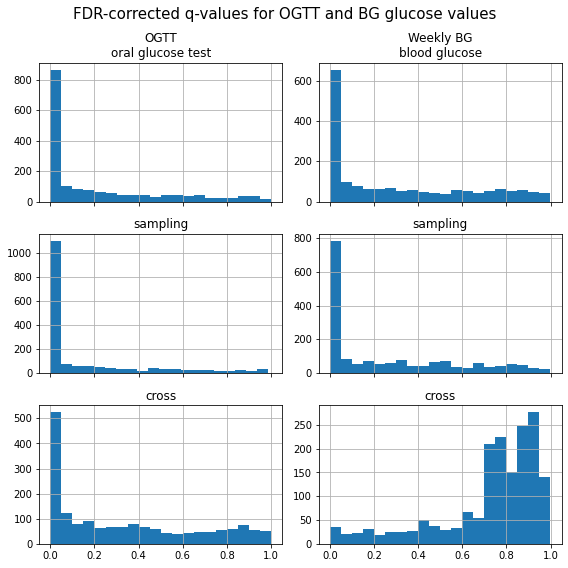

In [172]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8), sharex=True)

ogtt['fdr_gluc_qval'].hist(bins=20, ax=ax1)
ax1.set_title('OGTT\noral glucose test')
ogtt['fdr_sampling_qval'].hist(bins=20, ax=ax3)
ax3.set_title('sampling')
ogtt['fdr_cross_qval'].hist(bins=20, ax=ax5)
ax5.set_title('cross')

bg['fdr_gluc_qval'].hist(bins=20, ax=ax2)
ax2.set_title('Weekly BG\nblood glucose')
bg['fdr_sampling_qval'].hist(bins=20, ax=ax4)
ax4.set_title('sampling')
bg['fdr_cross_qval'].hist(bins=20, ax=ax6)
ax6.set_title('cross')

fig.suptitle('FDR-corrected q-values for OGTT and BG glucose values', fontsize=15)
plt.tight_layout()

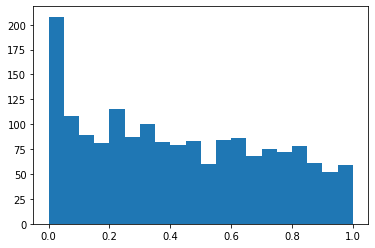

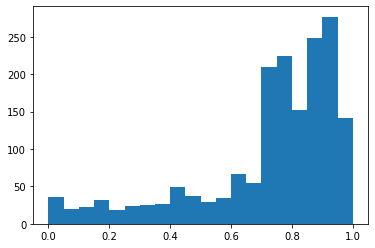

In [206]:
plt.hist(bg['cross_pval'], bins=20)
plt.figure()
plt.hist(bg['fdr_cross_qval'], bins=20);

# What is the overlap of features significant between both OGTT and Weekly BG for glucose tolerance? 

In [244]:
print(len(ogtt_gluc_signif.symmetric_difference(bg_gluc_signif)), 'features not in both')

395 features not in both


In [245]:
print(len(ogtt_gluc_signif.intersection(bg_gluc_signif)), 'features in both')

562 features in both


Text(0, 0.5, 'Weekly BG log q-value')

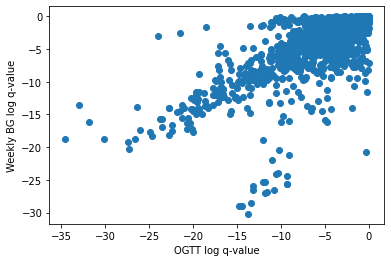

In [223]:
plt.scatter(np.log(ogtt['fdr_gluc_qval']), np.log(bg['fdr_gluc_qval']))
plt.xlabel('OGTT log q-value')
plt.ylabel('Weekly BG log q-value')

Index(['l_29', 'l_43', 'l_45', 'l_47', 'l_55', 'l_56', 'l_58', 'l_59', 'l_60',
       'l_67',
       ...
       'm_247', 'm_432', 'm_122', 'm_226', 'm_90', 'm_368', 'm_340', 'm_616',
       'm_557', 'm_169'],
      dtype='object', name='feature_name', length=957)

Text(0.5, 1.0, 'Showing only features significant in either model')

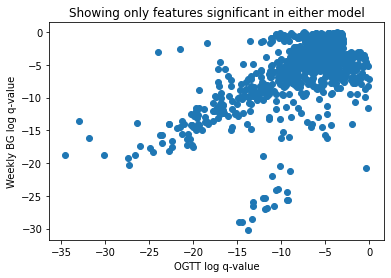

In [264]:
either_signif = ogtt[(ogtt['fdr_gluc_qval'] < 0.05) | (bg['fdr_gluc_qval'] < 0.05)].index
display(either_signif)
plt.scatter(np.log(ogtt.loc[either_signif, 'fdr_gluc_qval']), 
            np.log(bg.loc[either_signif, 'fdr_gluc_qval']))
plt.xlabel('OGTT log q-value')
plt.ylabel('Weekly BG log q-value')
plt.title('Showing only features significant in either model')

In [229]:
ogtt_gluc_signif = set(ogtt.loc[ogtt['fdr_gluc_qval'] < 0.05, 'fdr_gluc_qval'].index)
bg_gluc_signif = set(bg.loc[bg['fdr_gluc_qval'] < 0.05, 'fdr_gluc_qval'].index)

In [242]:
set([1,2,3]).intersection(set([2]))

{2}

In [240]:
set([2]).symmetric_difference(set([1,2,3]))

{1, 3}

# What is the effect of incorporating time into ogtt fixed effects model? 

In [ ]:
def fit_models(features):
    ogtt_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~        bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ ogtt          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ ogtt + bg_type', data=lmdata).fit()
        
        ogtt_result.append(get_model_params(feature_name=feature,
                                            value_type='ogtt',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    bg_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ bg * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~      bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ bg          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ bg + bg_type', data=lmdata).fit()

        bg_result.append(get_model_params(feature_name=feature,
                                          value_type='bg',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    return ogtt_result, bg_result

In [266]:
lmdata

,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,m_557,m_169,m_213,m_24,m_505,m_441,bg_type,bg,week,ogtt
1076_10_FBG,20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,19.856909,24.882649,20.930852,27.101820,20.783983,22.129900,FBG,71.000000,10,2321.25
1062_8_FBG,23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.968729,24.605962,21.303302,27.465801,21.295813,22.281020,FBG,52.333333,8,1648.75
1093_9_FBG,23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,20.559004,25.488336,19.581065,26.936184,19.838921,21.851189,FBG,64.000000,9,993.00
1060_8_RBG,24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,20.708589,24.568105,23.318774,27.795283,21.858665,22.537343,RBG,225.000000,8,1761.75
1091_10_FBG,24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.440626,24.949127,19.437282,27.044044,20.366726,21.887095,FBG,48.500000,10,846.75
1092_9_RBG,23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,21.073392,25.119634,23.268904,27.561589,21.397133,22.607897,RBG,70.500000,9,1377.95
1093_10_RBG,23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,21.153981,25.008021,23.345351,27.863524,21.742171,22.614663,RBG,69.500000,10,993.00
1082_10_FBG,23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,20.243994,24.852314,22.052052,27.438797,21.247307,22.346741,FBG,50.000000,10,2224.75
1060_9_RBG,24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,20.482364,25.064357,17.810755,26.430616,18.004667,22.303816,RBG,83.000000,9,1761.75
1101_9_FBG,23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,20.504512,24.826840,19.078979,26.924145,20.352671,21.932740,FBG,43.000000,9,2015.75


In [281]:
ogtt_time_result = []
for feature in feature_cols:
    full = smf.ols(f'{feature} ~ (ogtt * bg_type) + week', data=lmdata).fit()
    no_time = smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
    
    ogtt_time_result.append({'feature': feature, 'time_pval': full.compare_lr_test(no_time)[1]})

In [283]:
time_result = pd.DataFrame(ogtt_time_result)
time_result

,feature,time_pval
0,l_0,0.276245
1,l_1,0.897049
2,l_2,0.197006
3,l_3,0.073913
4,l_4,0.486627
...,...,...
1722,m_169,0.650903
1723,m_213,0.643224
1724,m_24,0.858481
1725,m_505,0.870860


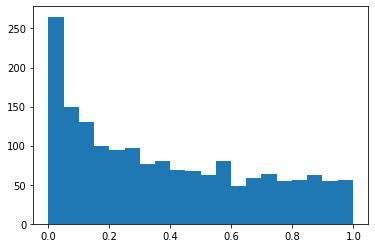

In [290]:
plt.hist(time_result['time_pval'], bins=20);

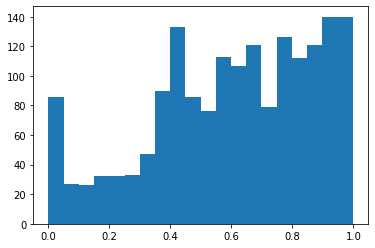

In [291]:
plt.hist(fdrcorrection(time_result['time_pval'])[1], bins=20);

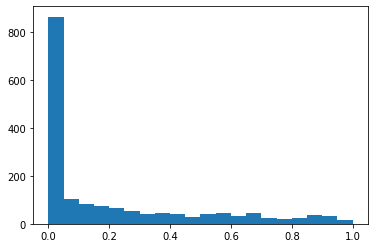

In [294]:
plt.hist(ogtt['fdr_gluc_qval'], bins=20);